There are 76,670 different agent ids in the training data.

In [1]:
import os
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')

In [3]:
# Keys to the pickle objects
CITY = 'city'
LANE = 'lane'
LANE_NORM = 'lane_norm'
SCENE_IDX = 'scene_idx'
AGENT_ID = 'agent_id'
P_IN = 'p_in'
V_IN = 'v_in'
P_OUT = 'p_out'
V_OUT = 'v_out'
CAR_MASK = 'car_mask'
TRACK_ID = 'track_id'

# Set the training and test paths
TEST_PATH = '../new_val_in/'
TRAIN_PATH = '../new_train/'
train_path = TRAIN_PATH
test_path = TEST_PATH

# DUMMY_TRAIN_PATH = './dummy_train/'
# DUMMY_TEST_PATH = './dummy_val/'
# train_path = DUMMY_TRAIN_PATH
# test_path = DUMMY_TEST_PATH

# Size of training and test data

In [4]:
train_size = len([entry for entry in os.scandir(train_path)])
test_size = len([entry for entry in os.scandir(test_path)])

print(f"Number of training samples = {train_size}")
print(f"Number of test samples = {test_size}")

Number of training samples = 205942
Number of test samples = 3200


# Scene object

In [5]:
# Open directory containing pickle files
with os.scandir(train_path) as entries:
    scene = None

    # Get the first pickle file
    entry = next(entries)
    
    # Open the first pickle file and store its data
    with open(entry, "rb") as file:
        scene = pickle.load(file)

# Look at key-value pairs
print('Scene object:')
for k, v in scene.items():
    if type(v) is np.ndarray:
        print(f"{k} : shape = {v.shape}")
    else:
        print(f"{k} : {type(v)}")

Scene object:
city : <class 'str'>
lane : shape = (72, 3)
lane_norm : shape = (72, 3)
scene_idx : <class 'int'>
agent_id : <class 'str'>
car_mask : shape = (60, 1)
p_in : shape = (60, 19, 2)
v_in : shape = (60, 19, 2)
p_out : shape = (60, 30, 2)
v_out : shape = (60, 30, 2)
track_id : shape = (60, 30, 1)


# Scene Analysis

In [6]:
random.seed(1)

In [7]:
def lane_centerline(scene):
    lane = scene[LANE]
    lane_norm = scene[LANE_NORM]
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    ax1.quiver(lane[:, 0], lane[:, 1], lane_norm[:, 0], lane_norm[:, 1], color='gray')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Lane centerline')

In [8]:
def target_agent(scene):
    lane = scene[LANE]
    lane_norm = scene[LANE_NORM]
    
    pin = scene[P_IN]
    pout = scene[P_OUT]
    vin = scene[V_IN]
    vout = scene[V_OUT]
    # Get the index of the target agent
    targ = np.where(scene[TRACK_ID][:, 0, 0] == scene[AGENT_ID])[0][0]
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Target agent motion')    
    
    ax1.quiver(lane[:, 0], lane[:, 1], lane_norm[:, 0], lane_norm[:, 1], units='xy', color='black')
    ax1.quiver(pin[targ, :, 0], pin[targ, :, 1], vin[targ, :, 0], vin[targ, :, 1], color='red', units='xy');
    ax1.quiver(pout[targ, :, 0], pout[targ, :, 1], vout[targ, :, 0], vout[targ, :, 1], color='blue', units='xy');

In [31]:
def full_scene(scene):
    lane = scene[LANE]
    lane_norm = scene[LANE_NORM]
    
    pin = scene[P_IN]
    pout = scene[P_OUT]
    vin = scene[V_IN]
    vout = scene[V_OUT]
    # Get the index of the target agent
    targ = np.where(scene[TRACK_ID][:, 0, 0] == scene[AGENT_ID])[0][0]
    
    actual_idxs = np.where(scene[CAR_MASK][:, 0] == 1)  # Row indexes of actually tracked agents
    pin_other = scene[P_IN][actual_idxs]
    vin_other = scene[V_IN][actual_idxs]
    pout_other = scene[P_OUT][actual_idxs]
    vout_other = scene[V_OUT][actual_idxs]
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Scene ' + str(scene[SCENE_IDX]))
    ax1.quiver(lane[:, 0], lane[:, 1], lane_norm[:, 0], lane_norm[:, 1], units='xy', color='gray', label='Center line(s)')
    
    # Index of the last other agent - can either be the last element in the array or the element right before
    # target when target is the last element in the array
    last_other = len(actual_idxs[0]) - 1 if targ != len(actual_idxs[0]) - 1 else targ - 1
    
    for i in range(len(actual_idxs[0])):
        # Non target agent
        if i != targ:
            if i == last_other:
                ax1.quiver(pin[i, :, 0], pin[i, :, 1], vin[i, :, 0], vin[i, :, 1], 
                           color='orange', units='xy', label='Other agent input')
                ax1.quiver(pout[i, :, 0], pout[i, :, 1], vout[i, :, 0], vout[i, :, 1], 
                           color='blue', units='xy', label='Other agent output')
            else:
                ax1.quiver(pin[i, :, 0], pin[i, :, 1], vin[i, :, 0], vin[i, :, 1], 
                           color='orange', units='xy', label='_nolegend_')
                ax1.quiver(pout[i, :, 0], pout[i, :, 1], vout[i, :, 0], vout[i, :, 1], 
                           color='blue', units='xy', label='_nolegend_')
                set_other_legend = True
                
        else:
            ax1.quiver(pin[targ, :, 0], pin[targ, :, 1], vin[targ, :, 0], vin[targ, :, 1], 
                       color='lightgreen', units='xy', label='Target agent input')
            ax1.quiver(pout[targ, :, 0], pout[targ, :, 1], vout[targ, :, 0], vout[targ, :, 1], 
                       color='darkgreen', units='xy', label='Target agent output')
        
                
    ax1.legend()

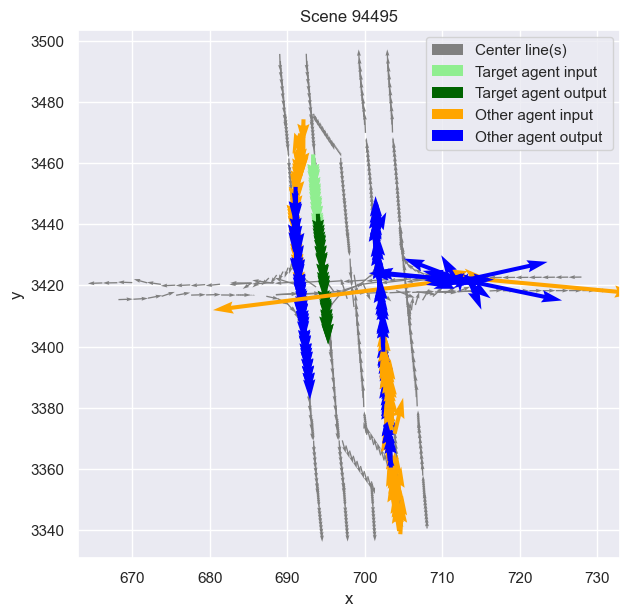

In [40]:
# Randomly pick a scene
scene = None
rand = random.choice(os.listdir(train_path))
# Build out full path name
rand = train_path + rand
with open(rand, "rb") as file:
    scene = pickle.load(file)
    
scene[SCENE_IDX]
# lane_centerline(scene)
# target_agent(scene)
full_scene(scene)